<a href="https://colab.research.google.com/github/NoelleI/Udacity-Deployment/blob/master/Heartbeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [252]:


'''Step 1 Detect Skin 
this code was adapted from https://www.pyimagesearch.com/2014/08/18/skin-detection-step-step-example-using-python-opencv/
and
https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/'''

# import the necessary packages
import imutils
import numpy as np
import argparse
import cv2
from matplotlib import pyplot
from google.colab.patches import cv2_imshow
# construct the argument parse and parse the arguments

# define the upper and lower boundaries of the HSV pixel
# intensities to be considered 'skin'
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")
# if a video path was not supplied, grab the reference
# to the gray


camera = cv2.VideoCapture("IMG_3833 (1).MOV")  
n_frames = int(camera.get(cv2.CAP_PROP_FRAME_COUNT))
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
print(n_frames)

''''change this'''


ra = []
ga = []
ba = []
box = []

# keep looping over the frames in the video
for i in range(n_frames):
    
    print(i)
	# grab the current frame
    (grabbed, frame) = camera.read()
	# if we are viewing a video and we did not grab a
	# frame, then we have reached the end of the video
	# resize the frame, convert it to the HSV color space,
	# and determine the HSV pixel intensities that fall into
	# the speicifed upper and lower boundaries
    if grabbed:
        frame = imutils.resize(frame, width = 400)
        frame = imutils.rotate(frame, -90)
        converted = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        skinMask = cv2.inRange(converted, lower, upper)
	# apply a series of erosions and dilations to the mask
	# using an elliptical kernel
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        skinMask = cv2.erode(skinMask, kernel, iterations = 2)
        skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
	# blur the mask to help remove noise, then apply the
	# mask
        skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
        skin = cv2.bitwise_and(frame, frame, mask = skinMask)

        bboxes = classifier.detectMultiScale(skin, 1.05, 8)
        print('len bboxes:', len(bboxes))
        if box == []:  
          if len(bboxes) ==0:
            print("face not detected in first frame")
            cv2_imshow(np.vstack([frame, skin]))  ##change to an assert later
          else:
            box = bboxes[0]
#choose the box most like the last frame, if more than one box. If zero boxes, use box from last frame
        else:
          if len(bboxes) ==0:
            box = box   
            print("old box used") 
          else:
           test2 = np.zeros(len(bboxes))
           for i, boxnew in enumerate(bboxes):
            [xn, yn, widthn, heightn] = boxnew 
            x2n = xn + widthn
            y2n = yn + heightn
           	# draw a rectangle mask and compare to box from previous frame
            tempn = np.zeros([frame.shape[0], frame.shape[1]])
            tempn = tempn.astype(np.uint8)
            cv2.rectangle(tempn, (xn, yn), (x2n, y2n), (255,255,255), -1)
            test = cv2.bitwise_and(temp, temp, mask = tempn)
            test2[i] = np.mean(test)
           boxt = bboxes[np.argmax(test2)]
           if boxt[3] <= width*0.9 or boxt[3] >= width*1.1:
             box = box
             print("old box used")
           else:
             box = boxt
             print("nearest box used")
	# extract
        [x, y, width, height] = box 
        x2 = x + width
        y2 = y + height
        x2 = int(x2 - 0.2*width)
        x = int(x + 0.2*width)
        #y2 = int(y2 - 0.8*height)
           	# draw a rectangle over the pixels
        temp = np.zeros([frame.shape[0], frame.shape[1]])
        cv2.rectangle(temp, (x, y), (x2, y2), (255,255,255), -1)
        temp = temp/255
        temp = temp.astype(np.uint8)
        skin = cv2.bitwise_and(skin, skin, mask = temp)



        #find the average red, green and blue in the skin
        N = 0
        r=0
        g=0
        b=0
        skinr = skin[:,:,0].reshape(-1)
        sking = skin[:,:,1].reshape(-1)
        skinb = skin[:,:,2].reshape(-1)

        #print(skinMask.shape)
        for i, pixel in enumerate(skinMask.reshape(-1)):
          if  not pixel==0:
            r += skinr[i]
            g += sking[i]
            b += skinb[i]
            N+=1
        ra += [r/N] 
        ga += [g/N]
        ba += [b/N]




	# show the skin in the image along with the mask
      
        #cv2_imshow(np.vstack([frame, skin]))
# cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()

1815
0
len bboxes: 1
1
len bboxes: 1
nearest box used


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Streaming output truncated to the last 5000 lines.
len bboxes: 1
nearest box used
148
len bboxes: 0
old box used
149
len bboxes: 1
nearest box used
150
len bboxes: 1
nearest box used
151
len bboxes: 1
nearest box used
152
len bboxes: 1
nearest box used
153
len bboxes: 1
nearest box used
154
len bboxes: 1
nearest box used
155
len bboxes: 0
old box used
156
len bboxes: 1
nearest box used
157
len bboxes: 1
nearest box used
158
len bboxes: 1
old box used
159
len bboxes: 1
nearest box used
160
len bboxes: 1
nearest box used
161
len bboxes: 1
nearest box used
162
len bboxes: 1
nearest box used
163
len bboxes: 0
old box used
164
len bboxes: 0
old box used
165
len bboxes: 0
old box used
166
len bboxes: 0
old box used
167
len bboxes: 0
old box used
168
len bboxes: 0
old box used
169
len bboxes: 0
old box used
170
len bboxes: 1
nearest box used
171
len bboxes: 0
old box used
172
len bboxes: 0
old box used
173
len bboxes: 0
old box used
174
len bboxes: 0
old box used
175
len bboxes: 0
old box use

In [253]:
ra = np.array(ra)

In [254]:
np.argmin(ra)

1285

In [255]:
ra[np.argmin(ra)]

23.83124637939486

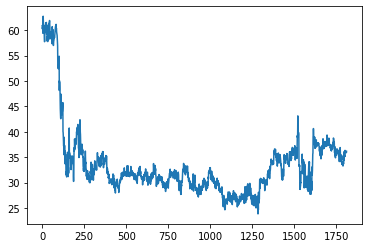

In [256]:
import matplotlib.pyplot as plt

plt.plot(ra)

In [257]:
ga = np.array(ga)
ba = np.array(ba)

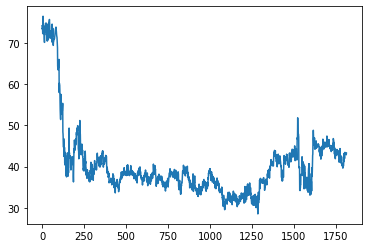

In [258]:
plt.plot(ga)

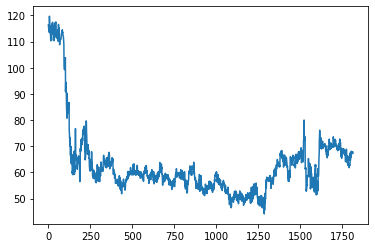

In [259]:
plt.plot(ba)

In [260]:
from sklearn.decomposition import FastICA
from scipy import signal
transformer = FastICA(n_components=3)

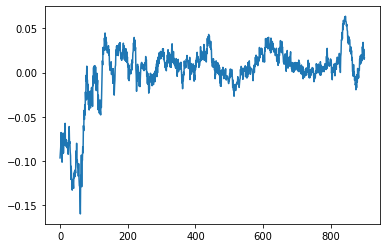

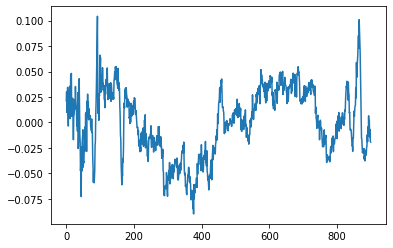

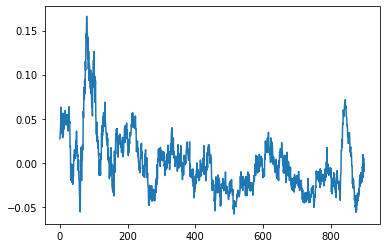

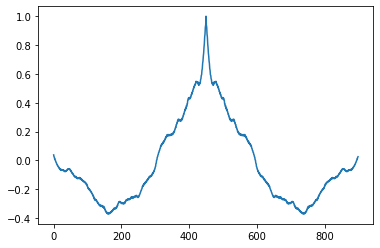

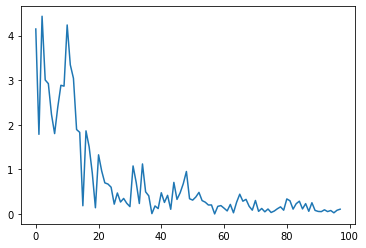

4.433177416166494 4.237411151843381
waiting


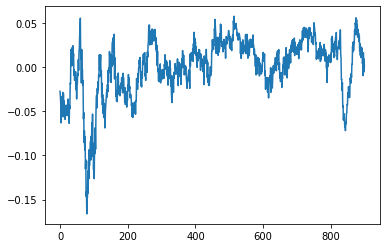

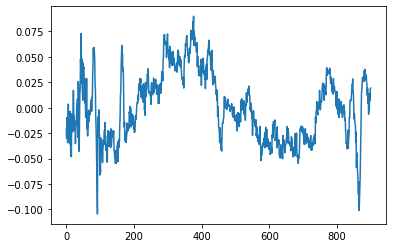

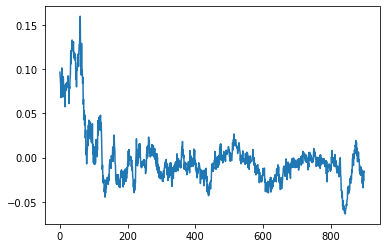

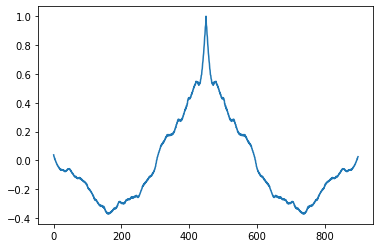

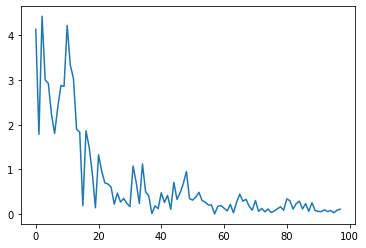

4.42914271451611 4.2232732344490955
waiting


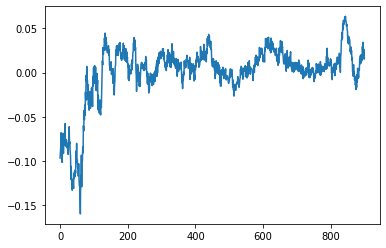

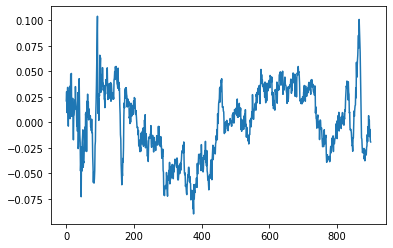

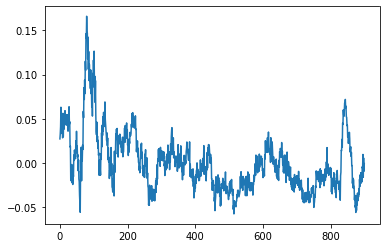

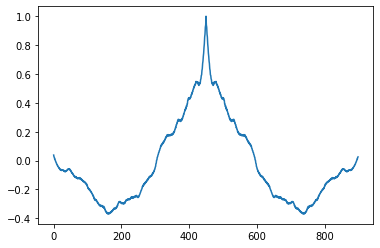

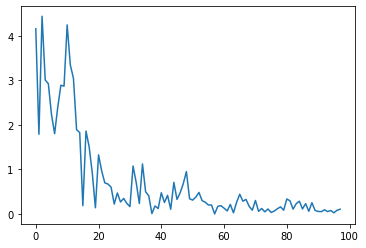

4.439385983288486 4.244843506264067
waiting


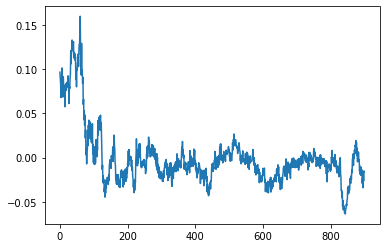

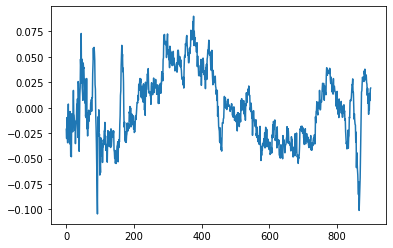

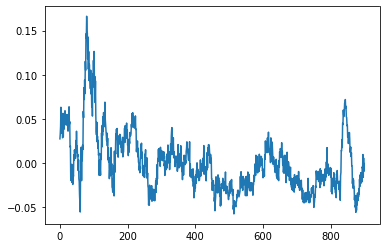

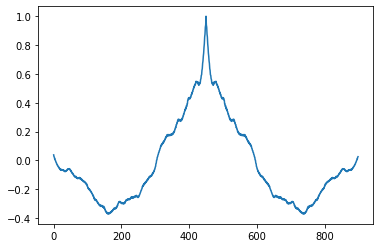

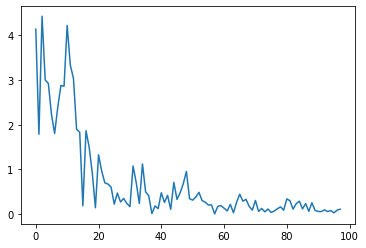

4.429433036685645 4.224237140390945
waiting


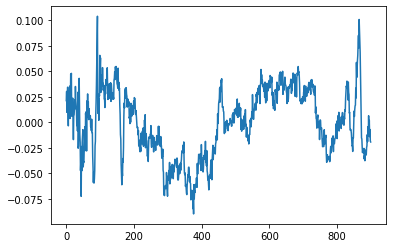

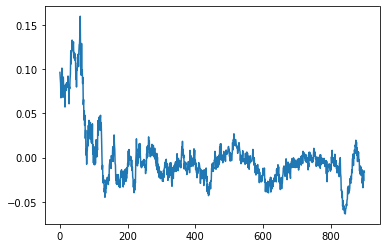

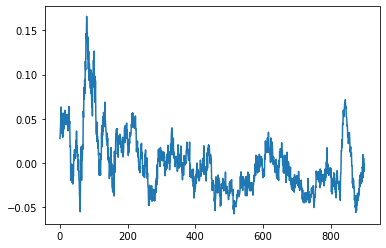

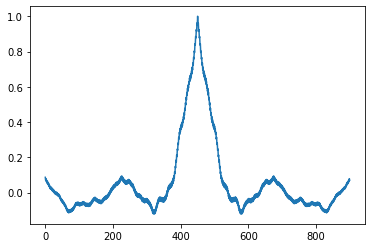

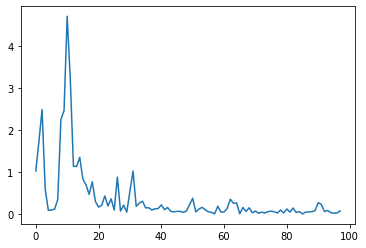

4.7078011723227 2.485970162705241
estimated heartrate  64.0


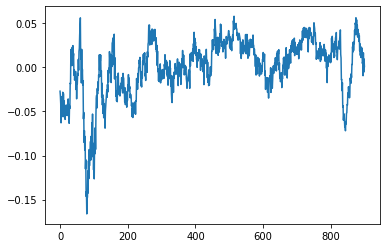

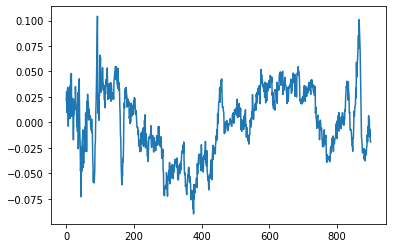

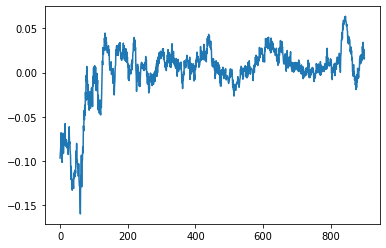

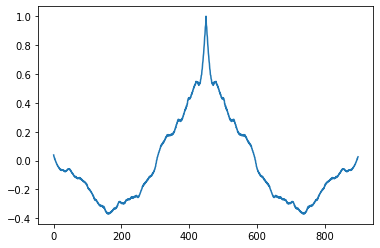

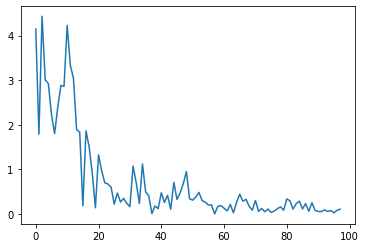

4.433957045094348 4.229261746455292
waiting


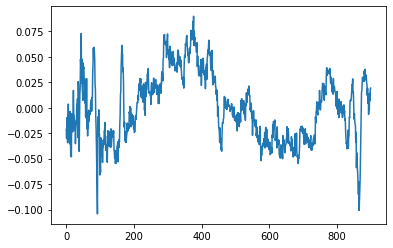

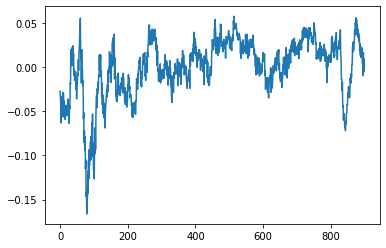

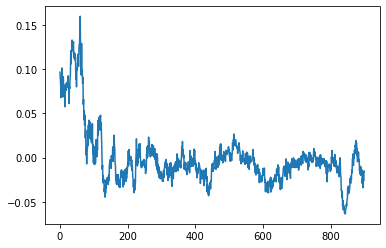

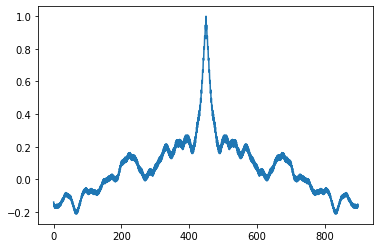

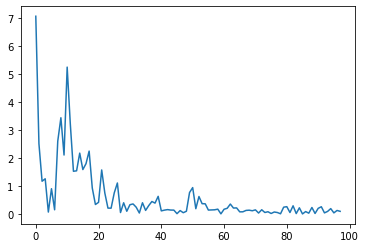

7.077651113140185 5.256431404239841
waiting


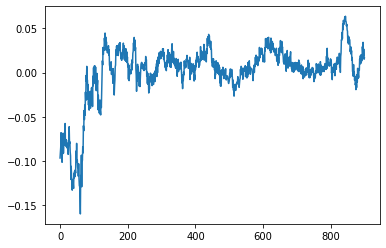

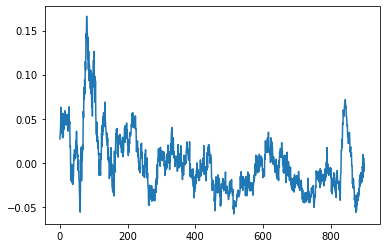

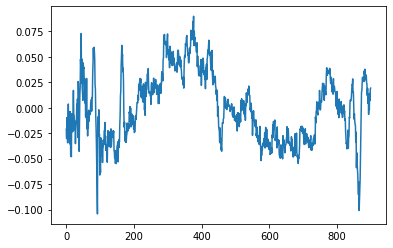

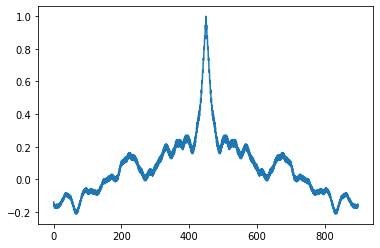

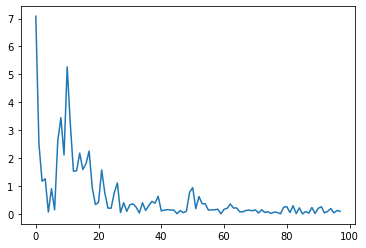

7.0816649361114745 5.265837428470195
waiting


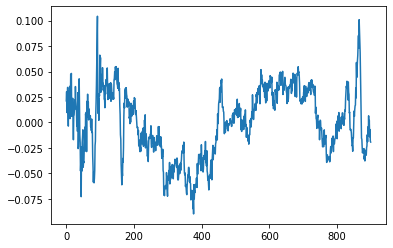

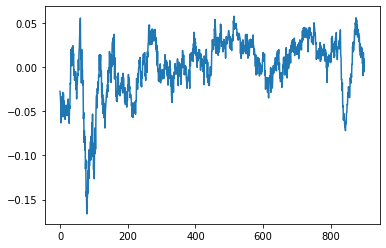

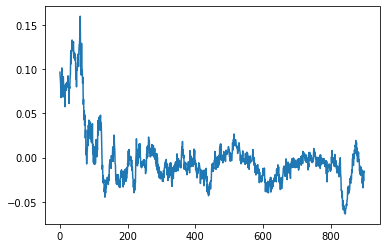

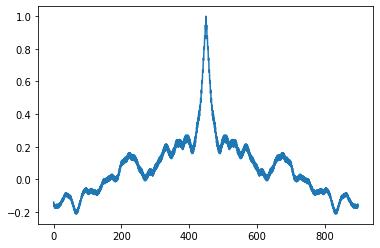

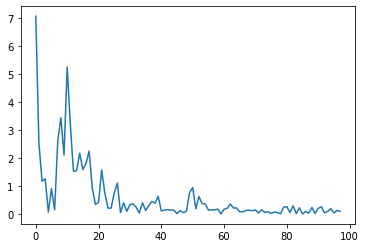

7.079575711671835 5.259918534335101
waiting


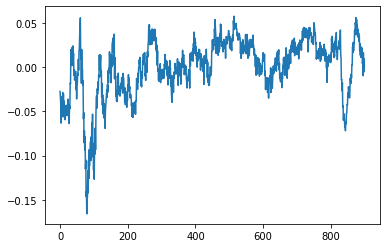

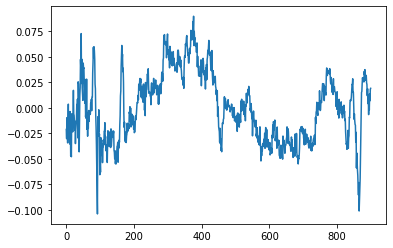

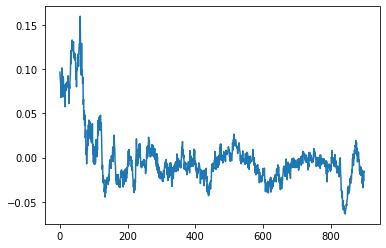

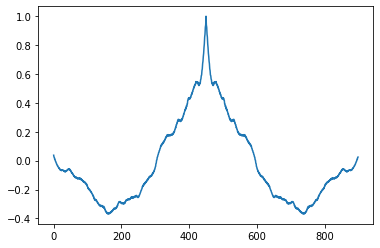

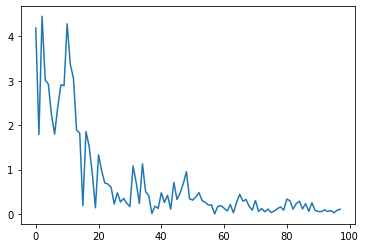

4.451507076090984 4.280610761306234
waiting


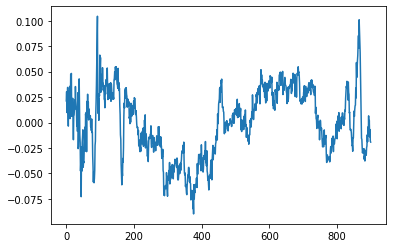

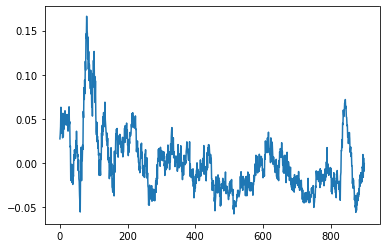

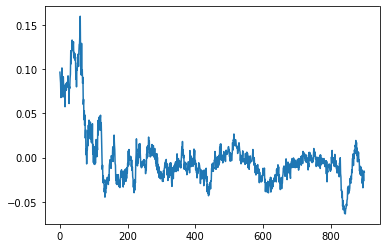

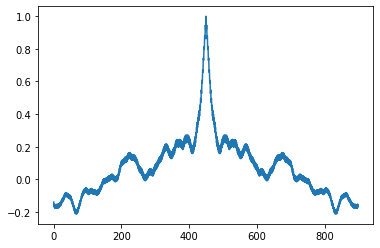

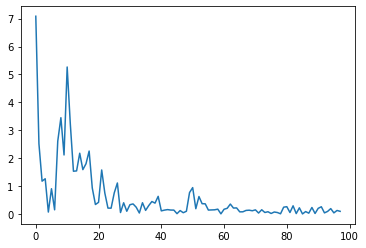

7.084759669232145 5.26567402255162
waiting


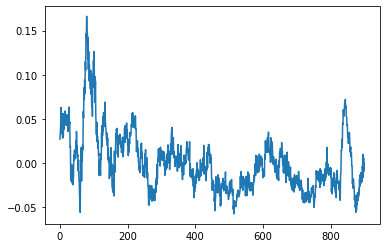

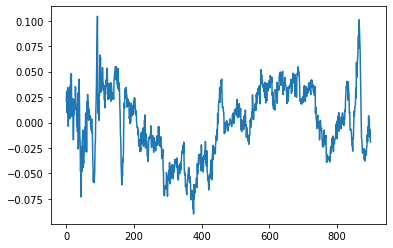

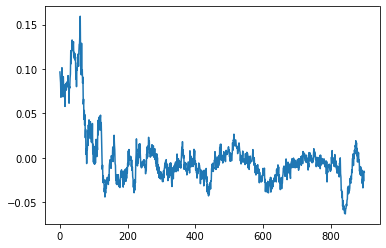

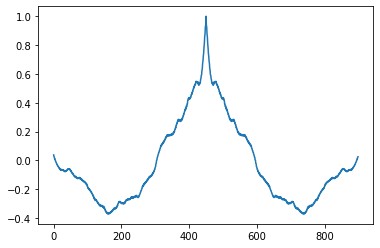

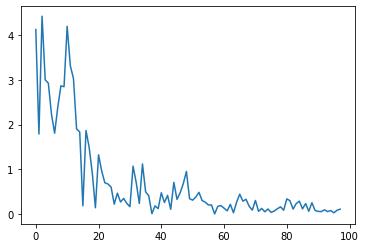

4.425094232360718 4.199686236615246
waiting


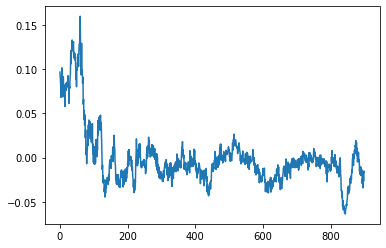

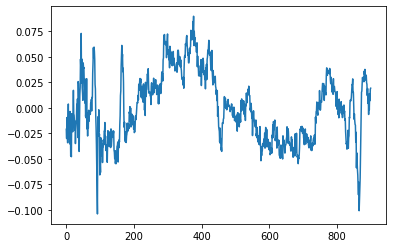

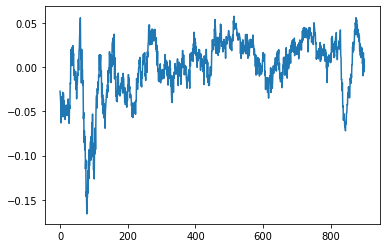

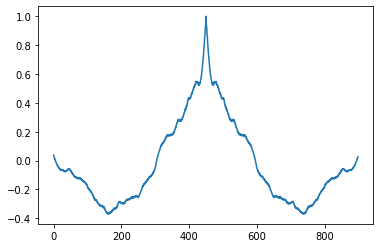

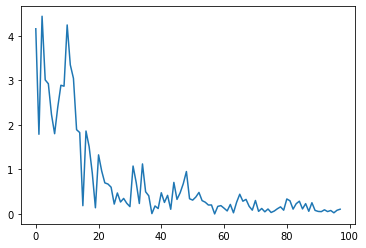

4.439288012201557 4.24354609787238
waiting


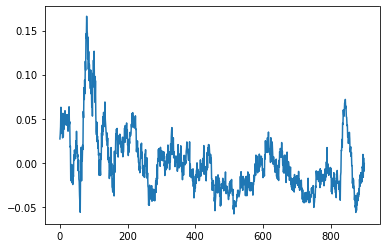

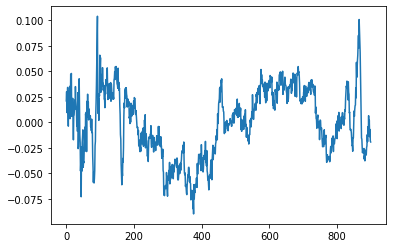

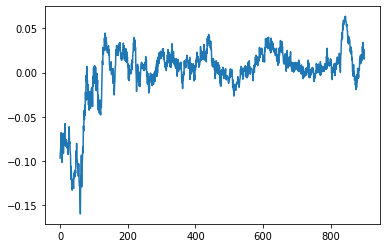

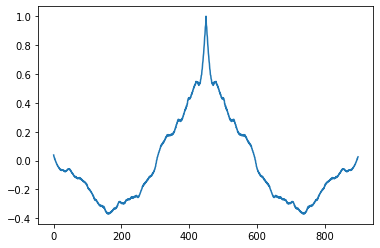

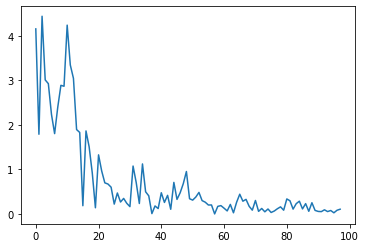

4.436482336123122 4.236714525078818
waiting


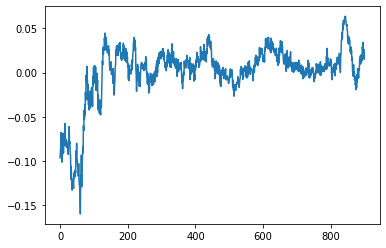

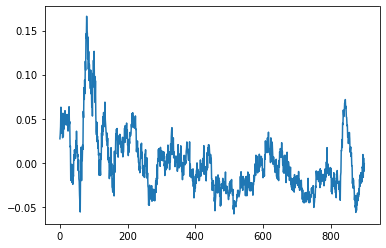

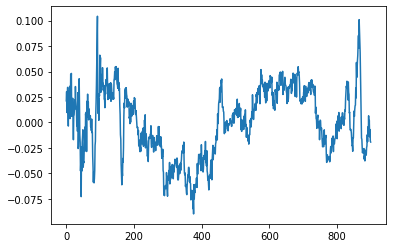

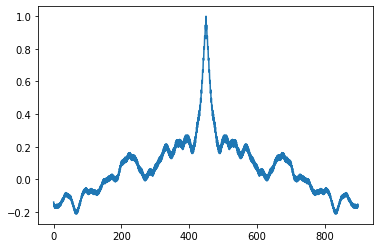

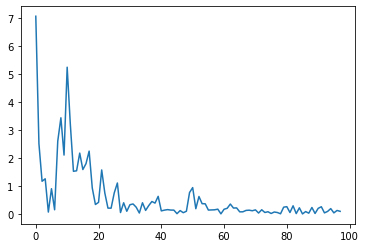

7.073724078474982 5.250280561211024
waiting


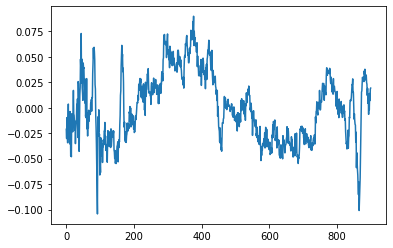

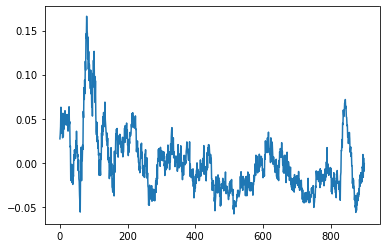

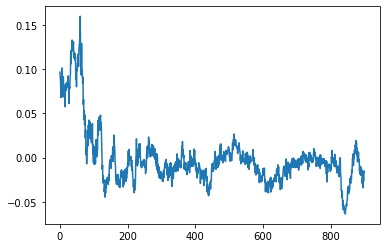

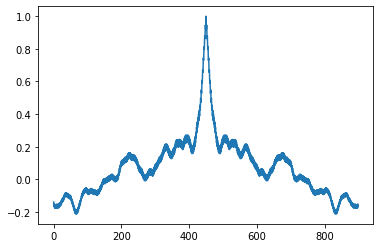

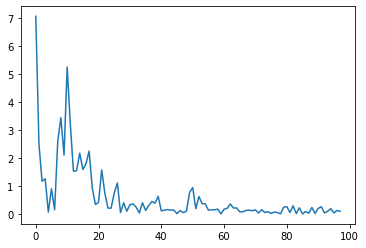

7.077896182754102 5.2579885550316545
waiting


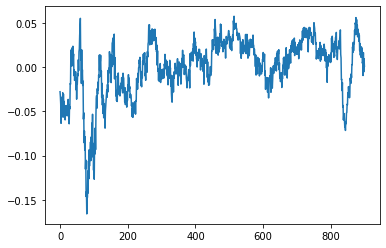

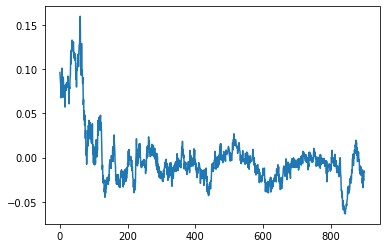

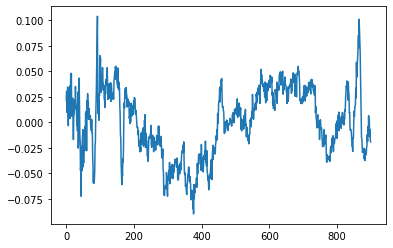

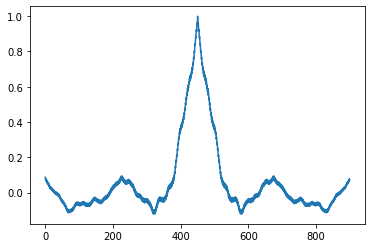

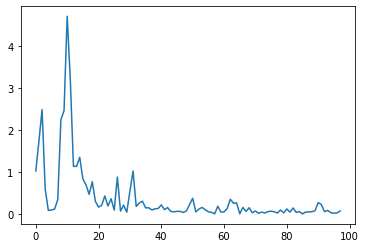

4.706973937025505 2.486287131725765
estimated heartrate  64.0


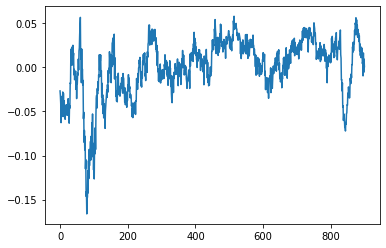

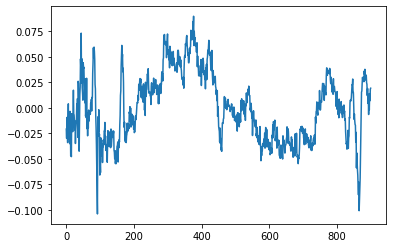

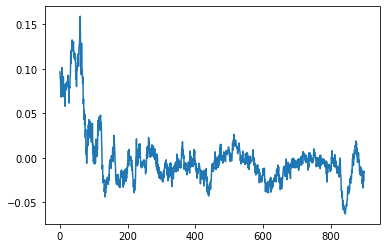

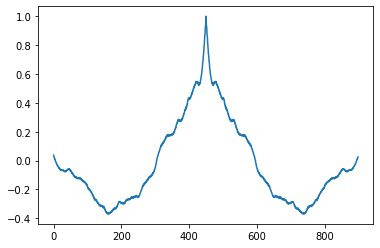

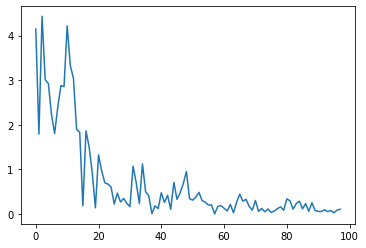

4.435128761370469 4.220188798444149
waiting


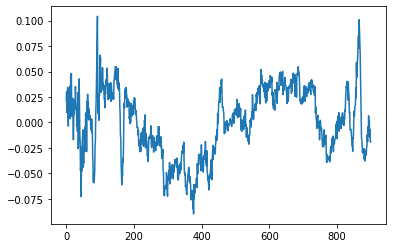

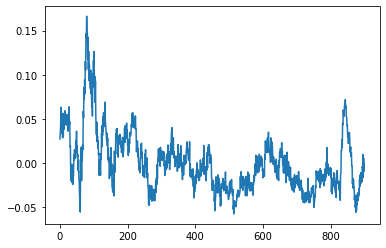

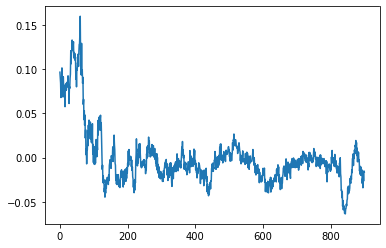

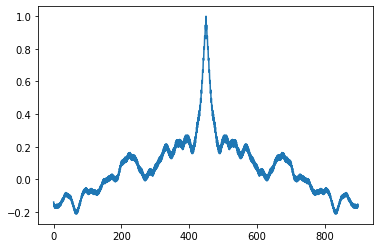

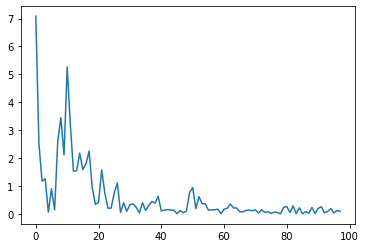

7.082983912535987 5.265096123802292
waiting


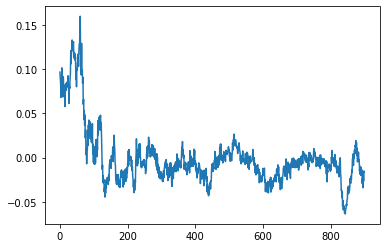

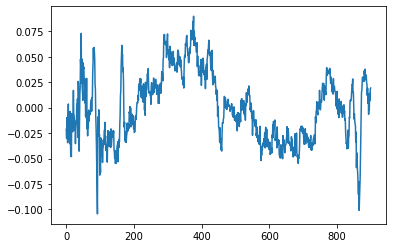

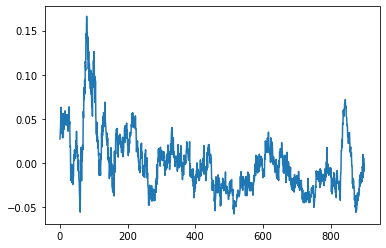

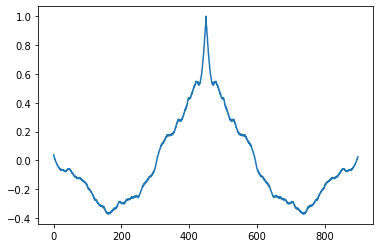

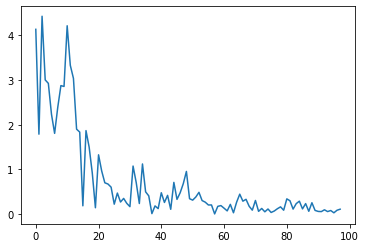

4.427368863401064 4.214205386021938
waiting


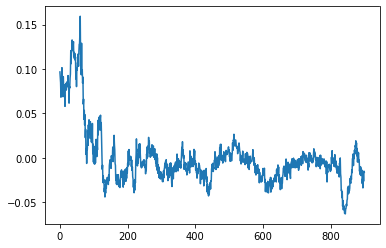

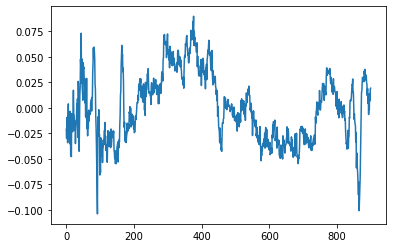

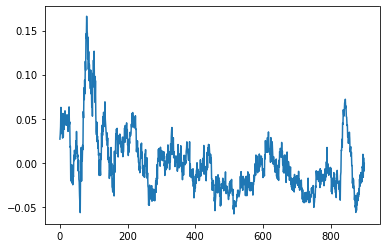

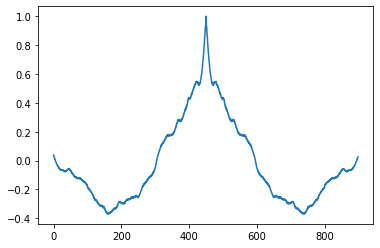

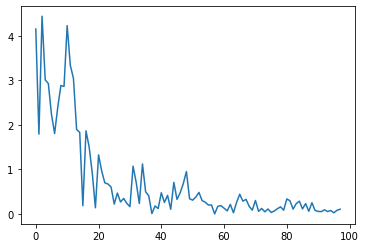

4.436040709492761 4.226530287560889
waiting


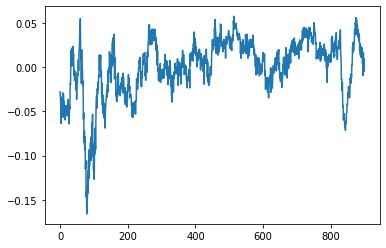

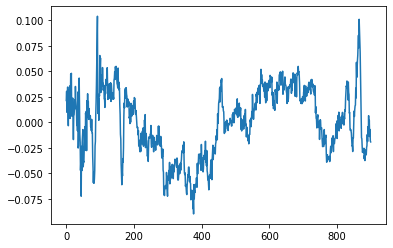

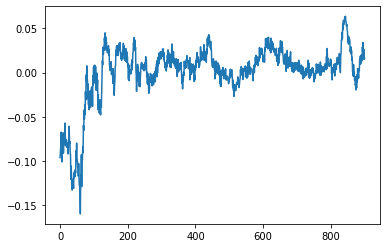

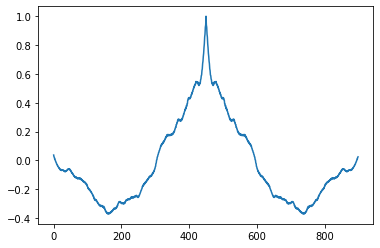

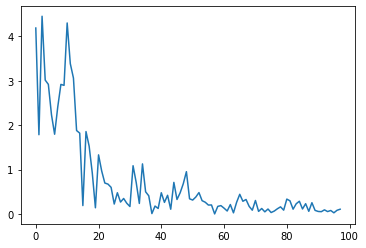

4.451222155530466 4.299824401020699
waiting


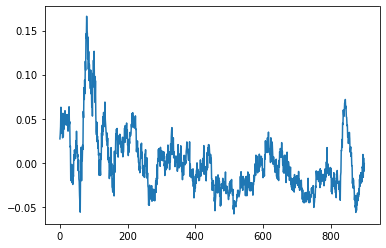

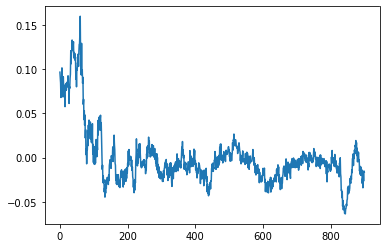

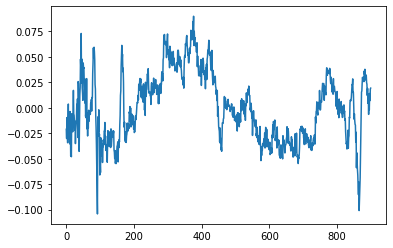

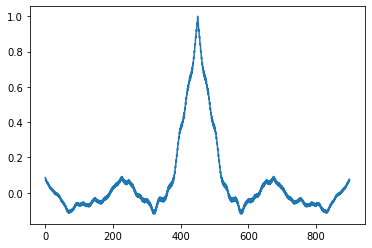

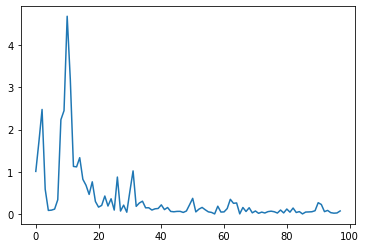

4.688892175400952 2.4788136834778274
estimated heartrate  64.0


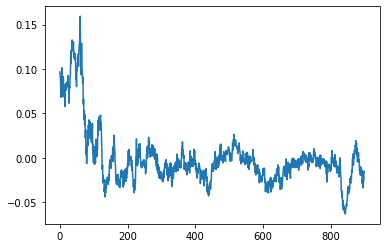

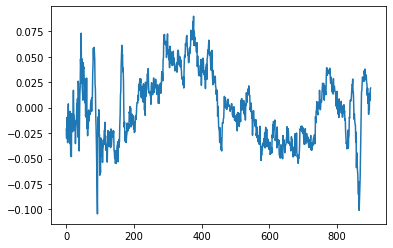

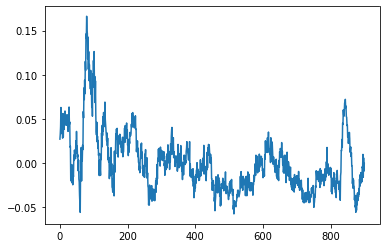

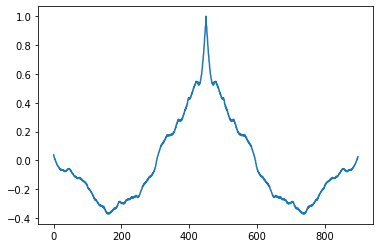

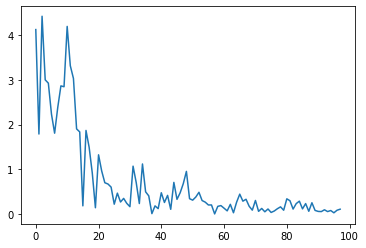

4.423483869901617 4.196005529287852
waiting


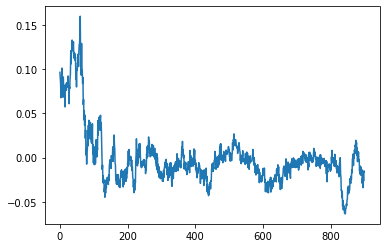

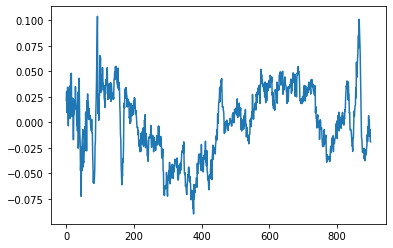

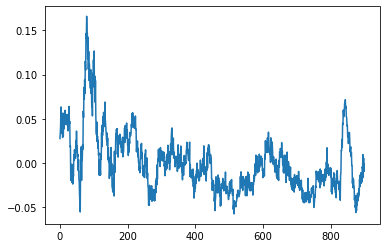

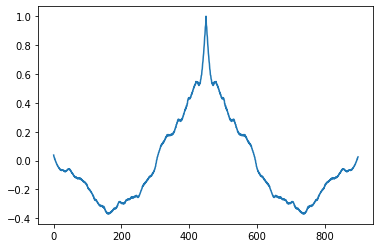

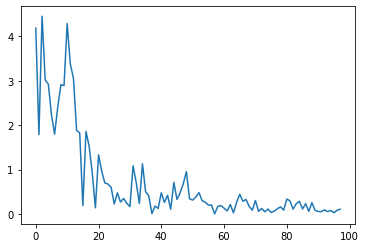

4.449069133880735 4.285328999470628
waiting


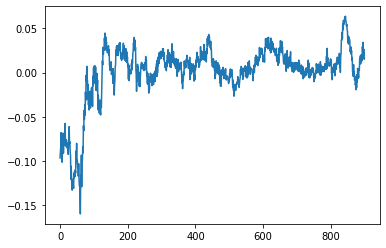

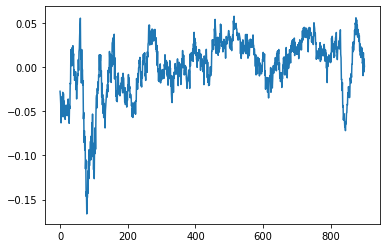

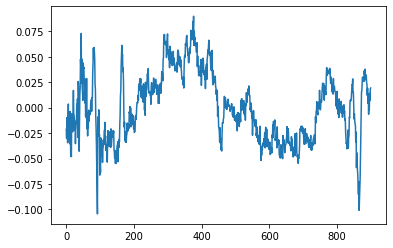

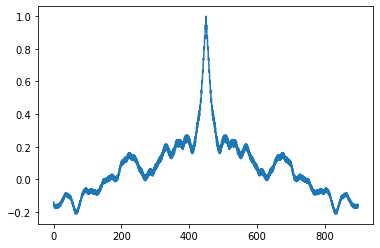

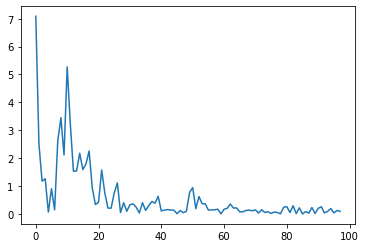

7.087999939147055 5.269695993614609
waiting


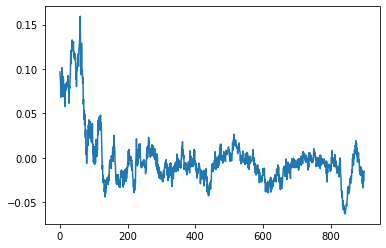

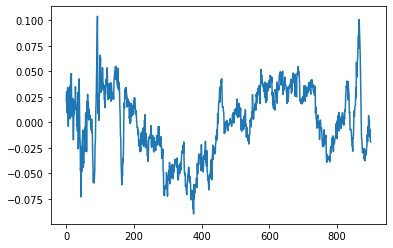

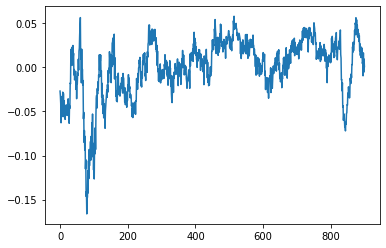

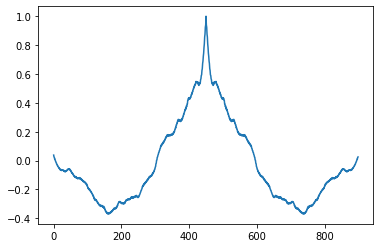

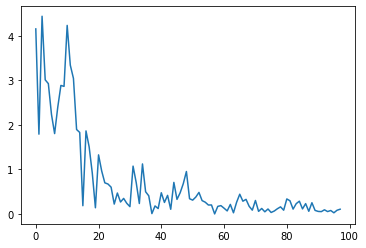

4.437163946346566 4.231559131605155
waiting


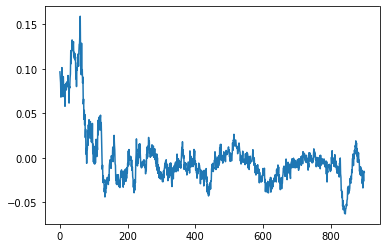

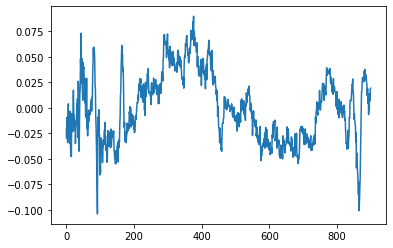

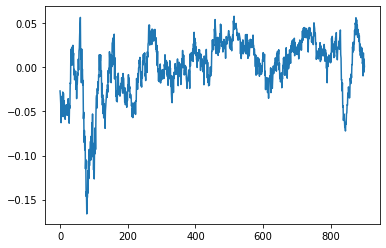

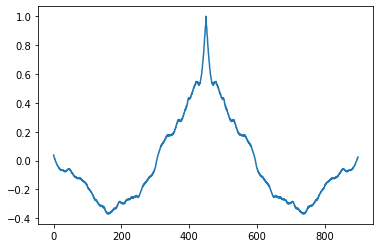

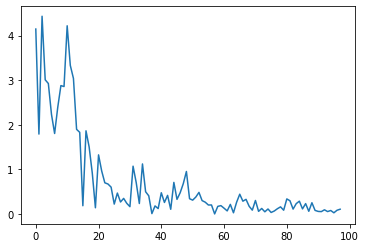

4.434996535883656 4.220980399551554
waiting


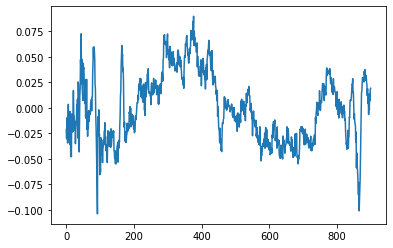

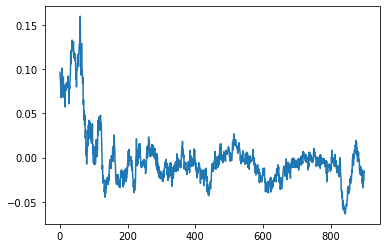

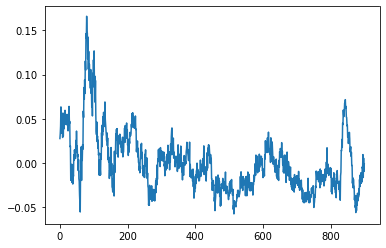

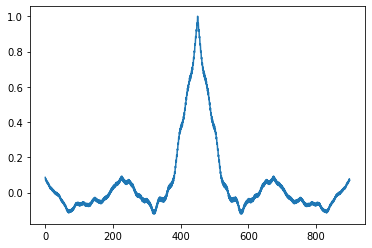

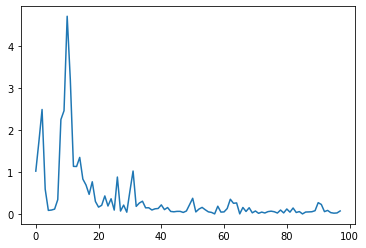

4.699815085860101 2.4837550577666008
estimated heartrate  64.0


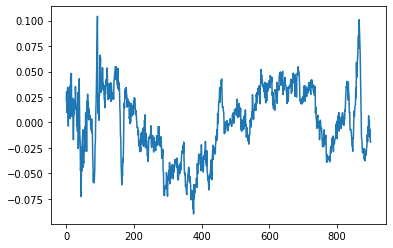

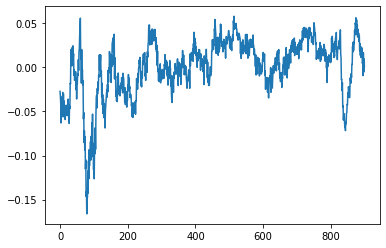

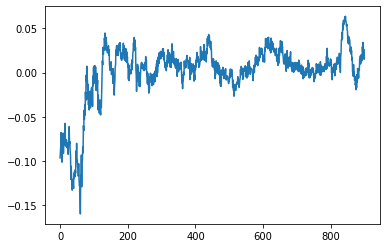

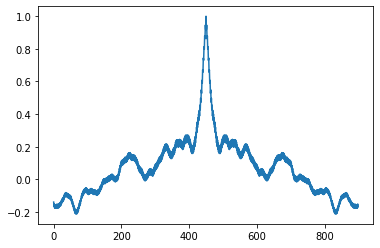

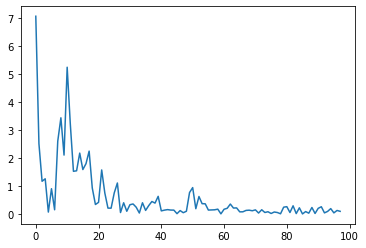

7.073069604101384 5.248938712629137
waiting


In [261]:
#normalize over 30s windows as in Poe et al.
n30 = int((n_frames - 900)/30) #number of 30 second sliding windows
ran = np.zeros(900)
gan = np.zeros(900)
ban = np.zeros(900)
for i in range(n30):
  rav = np.mean(ra[i*30:i*30+900])
  gav = np.mean(ga[i*30:i*30+900])
  bav = np.mean(ba[i*30:i*30+900])
  rstd = np.std(ra[i*30:i*30+900])
  gstd = np.std(ga[i*30:i*30+900])
  bstd = np.std(ba[i*30:i*30+900])
  for j in range(900):
    ran[j] = (ra[j] - rav)/rstd
    gan[j] = (ga[j] - gav)/gstd
    ban[j] = (ba[j] - bav)/bstd
  X = np.array(list(zip(ran,gan,ban)))
  X_transformed = transformer.fit_transform(X)
  X_indep = X_transformed.transpose()
  plt.plot(X_indep[0])
  plt.show()
  plt.plot(X_indep[1])
  plt.show()
  plt.plot(X_indep[2])
  plt.show()
  x1 = X_indep[1]
  x1_corr = signal.correlate(x1, x1, mode='same')
  plt.plot(x1_corr)
  plt.show()
  ff = np.fft.hfft(x1_corr[:int(len(x1_corr)/2)])
  fs_n = 30/len(x1_corr/2)
  upper = int(4/fs_n)
  lower = int(0.75/fs_n)
  plt.plot((abs(ff[lower:upper])))
  plt.show()
  hr1 = int((np.argmax(abs(ff[lower:upper])) + lower))
  max1 = np.max(abs(ff[lower:upper]))
  hr2array = np.concatenate([ff[lower:hr1 - 2], ff[hr1 + 2:upper]], axis = 0)
  max2 = np.max(abs(hr2array))
  print(max1, max2)
  if max2 <= 0.6*max1:
    hr1 = hr1*60*fs_n
    print("estimated heartrate ", hr1)
  else:
    print("waiting")



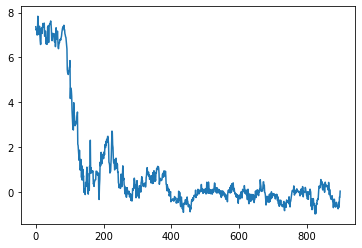

In [262]:
plt.plot(ran)

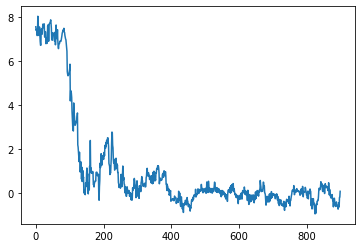

In [263]:
plt.plot(gan)

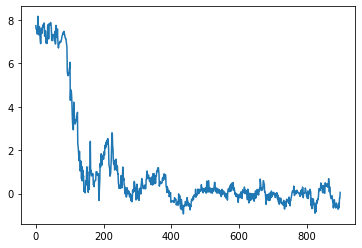

In [264]:
plt.plot(ban)